In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from ExKMC.splitters import get_min_mistakes_cut, get_min_surrogate_cut


sys.path.append("../main")
from tree import *
from rule_clustering import *
from utils import *
from experiments import *
from grid import *

%load_ext autoreload
%autoreload 2

In [4]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [5]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 14
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)
#subset_colors2 = [cmap(0), cmap(2), cmap(5), cmap(4), cmap(8), cmap(9),]
subset_colors2 = [cmap(0), cmap(2), cmap(9), cmap(4), cmap(7), cmap(8),]
cmap_subset2 = ListedColormap(subset_colors2)

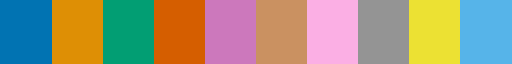

In [6]:
cmap

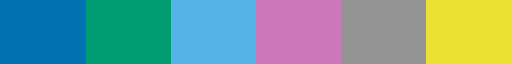

In [7]:
cmap_subset2

# Dataset

/project/mcnet/kevin/explainable_clustering/venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


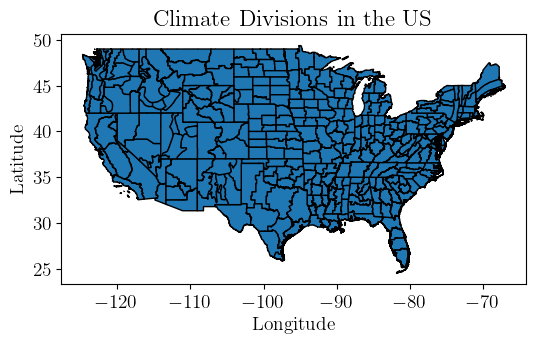

In [8]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

gdf.plot(figsize=(6, 6), edgecolor='black')
plt.title('Climate Divisions in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

In [10]:
climate_data

pcpn_jan  pcpn_feb  pcpn_mar  pcpn_apr  pcpn_may  pcpn_june  \
ID   Year                                                                
0101 1895      7.37      1.41      7.17      2.72      3.06       4.04   
     1896      2.47      7.46      6.23      4.34      2.92       4.50   
     1897      3.85      3.74     14.40      4.99      2.87       2.12   
     1898      7.07      1.34      4.43      4.29      1.86       2.61   
     1899      5.79      6.39      9.93      2.99      1.50       2.22   
...             ...       ...       ...       ...       ...        ...   
5013 2020      3.21      4.60      2.03      1.40      2.04       1.94   
     2021      5.02      5.64      3.09      2.64      2.79       2.50   
     2022      3.44      7.17      2.51      2.76      0.70       2.34   
     2023      3.71      3.83      4.87      1.88      3.27       2.06   
     2024      5.53      3.97      4.03      3.44      2.36       1.80   

           pcpn_july  pcpn_aug  pcpn_sept  pcpn_oct  ...  temp_mar  temp_apr  \
ID   Year                                            ...                       
0101 1895       4.58      4.00       3.41      2.28  ...      50.3      61.2   
     1896       3.78      1.94       2.67      1.59  ...      47.8      65.7   
     1897       3.93      3.66       0.03      1.74  ...      55.2      60.0   
     1898       5.52      3.67       2.83      3.72  ...      56.0      55.4   
     1899       6.04      3.44       0.57      1.85  ...      51.0      59.1   
...              ...       ...        ...       ...  ...       ...       ...   
5013 2020       2.76      3.24       6.04      4.18  ...      33.2      38.6   
     2021       2.09      2.61       3.53      9.21  ...      31.9      36.8   
     2022       2.96      6.06       4.25      5.75  ...      30.5      34.9   
     2023       5.39      2.87       5.34      3.34  ...      33.1      34.2   
     2024       3.74     -9.99      -9.99     -9.99  ...      29.5      35.2   

           temp_may  temp_june  temp_july  temp_aug  temp_sept  temp_oct  \
ID   Year                                                                  
0101 1895      66.8       75.8       77.0      78.1       75.2      54.3   
     1896      73.8       74.8       79.9      80.8       72.0      58.6   
     1897      66.1       78.5       80.2      77.8       74.8      64.8   
     1898      71.8       79.1       79.8      78.5       74.6      58.5   
     1899      74.3       78.8       79.9      80.8       71.0      64.2   
...             ...        ...        ...       ...        ...       ...   
5013 2020      42.2       47.4       52.0      50.9       45.5      40.9   
     2021      41.3       46.7       50.7      51.8       47.3      39.7   
     2022      39.7       46.9       50.0      51.1       48.4      41.8   
     2023      39.0       46.1       51.9      52.4       48.3      42.3   
     2024      38.4       44.7       50.3     -99.9      -99.9     -99.9   

           temp_nov  temp_dec  
ID   Year                      
0101 1895      50.1      42.1  
     1896      52.9      42.7  
     1897      50.3      43.1  
     1898      46.4      39.6  
     1899      53.0      39.9  
...             ...       ...  
5013 2020      36.3      30.6  
     2021      29.2      34.7  
     2022      37.3      33.7  
     2023      37.3      28.1  
     2024     -99.9     -99.9  

[46020 rows x 24 columns]

In [11]:
historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

# Some extra code for filtering instances with large values:
#threshold = 1

# Create a boolean mask where any value in a row is greater than the threshold
#mask = ((climate_change > threshold) | (climate_change < -threshold)).any(axis=1)

# Filter the DataFrame based on the mask
#climate_change = climate_change[~mask]

In [12]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

<Axes: >

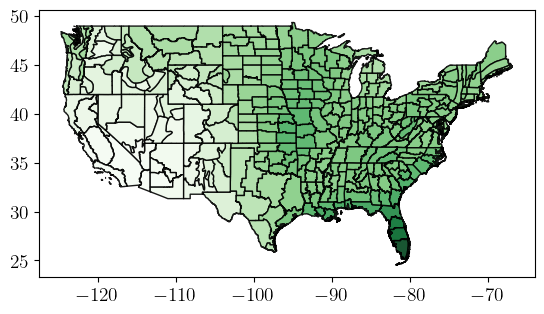

In [13]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(historical_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = historical_avg.loc[id, var]

gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

<Axes: >

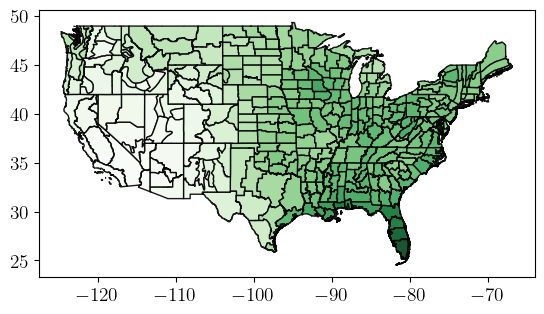

In [14]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(recent_avg.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = recent_avg.loc[id, var]
        
gdf['val'] = val_array
gdf.plot(column='val', cmap='Greens', legend=False, edgecolor = 'black', alpha = 0.9)

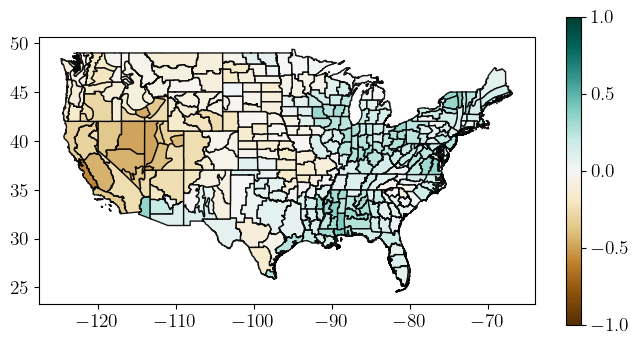

In [15]:
var = 'pcpn_june'
val_array = np.empty(len(gdf))
val_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        val_array[idx[0]] = climate_change.loc[id, var]
        
gdf['val'] = val_array

fig,ax = plt.subplots(figsize = (8,8))
gdf.plot(column='val', cmap='BrBG', ax = ax, vmin = -1, vmax = 1, legend=False, edgecolor = 'black', alpha = 0.9)
sm = plt.cm.ScalarMappable(cmap='BrBG', norm=plt.Normalize(vmin=-1, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink = 0.5)

In [16]:
climate_change

,pcpn_jan,pcpn_feb,pcpn_mar,pcpn_apr,pcpn_may,pcpn_june,pcpn_july,pcpn_aug,pcpn_sept,pcpn_oct,...,temp_mar,temp_apr,temp_may,temp_june,temp_july,temp_aug,temp_sept,temp_oct,temp_nov,temp_dec
ID,,,,,,,,,,,,,,,,,,,,,
2905,-0.030938,-0.217248,-0.320671,-0.404069,-0.204052,0.099656,0.056529,-0.162086,0.102329,-0.081426,...,0.077082,0.051805,0.028818,0.046744,0.038059,0.027483,0.041528,0.033872,0.060658,0.084255
2906,-0.156157,-0.299656,-0.216950,-0.310281,-0.229890,0.068542,-0.007252,-0.089024,0.028885,0.200843,...,0.087135,0.049023,0.027016,0.050387,0.044145,0.032264,0.049500,0.035546,0.058297,0.095653
1001,-0.098737,-0.040897,0.175809,0.098883,0.022068,-0.010902,-0.523080,-0.152467,-0.020648,0.101543,...,0.054926,0.006235,0.057019,0.046189,0.053419,0.060739,0.040385,0.027022,0.049622,0.042960
1002,-0.176396,0.214123,0.065458,0.097268,-0.051057,-0.084923,-0.598397,-0.219392,-0.124723,0.036413,...,0.042998,0.010755,0.043730,0.039428,0.043267,0.045884,0.034240,0.018335,0.030591,0.016510
1004,-0.211153,0.062531,0.041653,0.036466,-0.060523,-0.101367,-0.459143,-0.070443,0.055347,0.038356,...,0.084455,0.016827,0.043524,0.048410,0.047718,0.044913,0.040256,0.025190,0.056796,0.054584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0.031042,-0.391871,-0.219543,-0.358479,-0.239484,-0.088902,-0.101613,-0.063409,0.083249,0.375396,...,0.069497,0.031402,0.033017,0.046295,0.044481,0.037665,0.047976,0.033209,0.048690,0.093984
2901,0.147762,-0.117873,-0.185905,-0.483620,0.011190,-0.219368,-0.000435,-0.230803,0.017734,-0.286191,...,0.075447,0.041657,0.021077,0.052608,0.037410,0.028883,0.048531,0.023130,0.061275,0.075415
2902,0.093447,-0.111407,-0.128909,-0.402782,-0.074226,-0.083968,0.125937,-0.198664,0.123867,-0.010117,...,0.084182,0.036015,0.018593,0.043957,0.030458,0.019877,0.049445,0.026987,0.067528,0.093846


# Clustering Baselines

In [17]:
data = climate_change.to_numpy()
feature_labels = climate_change.columns

## k-means

In [18]:
k_trials = list(range(2,41))
trial_scores = [-1]*len(k_trials)
for i,k in enumerate(k_trials):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', n_init='auto', random_state = seed).fit(data)
    kmeans_clustering = labels_to_clustering(kmeans.labels_)
    trial_scores[i] = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)
    #trial_scores[i] = silhouette_score(data, kmeans.labels_)

Text(0, 0.5, 'Cost')

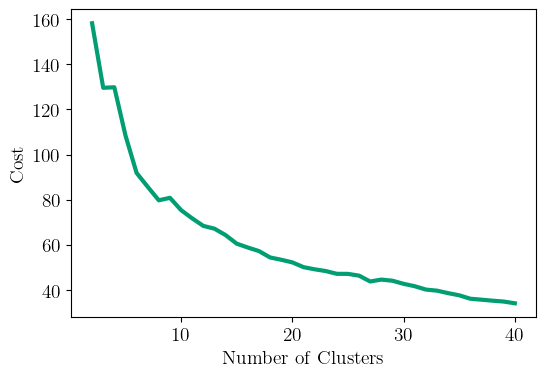

In [19]:
fig,ax = plt.subplots(figsize = (6,4))
ax.plot(k_trials, trial_scores, linewidth = 3, c = cmap(2))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

In [20]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto").fit(data)

In [21]:
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

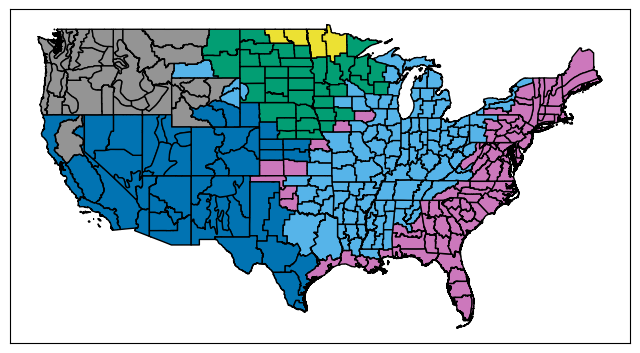

In [35]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate6/kmeans.png', bbox_inches = 'tight', dpi = 300)

### IMM

In [36]:
IMM_tree = ExTree(k, max_leaves = k, random_state = seed)
imm_labels = IMM_tree.fit_predict(data, kmeans)
imm_clustering = labels_to_clustering(imm_labels)
imm_centers = IMM_tree.all_centers
imm_cost = kmeans_cost(data, imm_clustering, imm_centers)

In [37]:
imm_cost

100.8187330069213

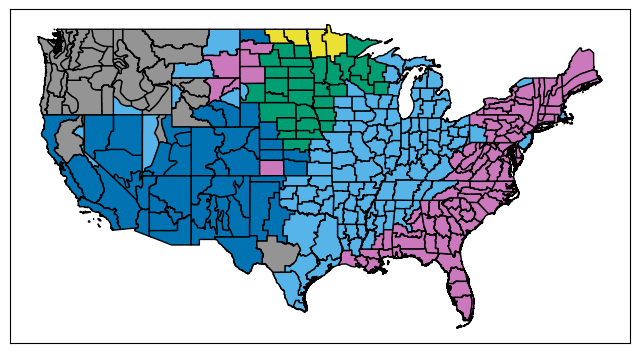

In [38]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = imm_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([])
#plt.savefig('figures/climate6/imm.png', bbox_inches = 'tight', dpi = 300)

In [39]:
converted_imm_tree = ConvertExKMC(IMM_tree.tree, data)

In [40]:
converted_imm_tree.depth

5

### ExKMC

In [41]:
ExKMC_tree = ExTree(k, max_leaves = k, base_tree = "NONE", random_state = seed)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_clustering = labels_to_clustering(exkmc_labels)
exkmc_centers = ExKMC_tree.all_centers
exkmc_cost = kmeans_cost(data, exkmc_clustering, exkmc_centers)

([], [])

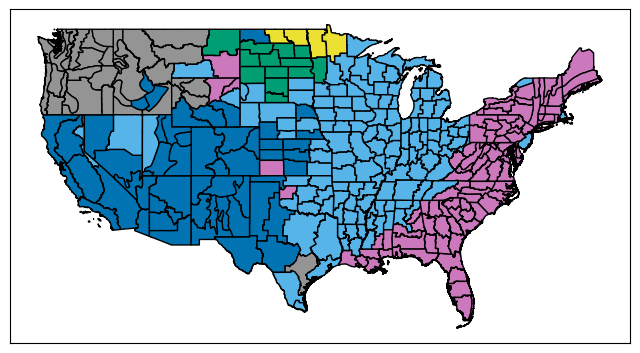

In [42]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = exkmc_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([])

In [43]:
#converted_exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
#visualize_tree(converted_exkmc_tree.root, feature_labels = feature_labels)

### Random Tree

In [45]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

random_tree_cost = np.inf
random_tree = None
random_tree_labels = None

for i in range(10000):
    random_tree_ = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree_.fit(kmeans.cluster_centers_)
    random_tree_labels_ = random_tree_.predict(data)
    random_tree_clustering_ = labels_to_clustering(random_tree_labels_)
    random_tree_centers_ = np.vstack([
                data[cluster, :].mean(axis=0) if len(cluster) > 0 else np.zeros(data.shape[1])
                for cluster in random_tree_clustering_
            ])
    #rcost = kmeans_cost(data, random_tree_clustering, kmeans.cluster_centers_)
    rcost = kmeans_cost(data, random_tree_clustering_, random_tree_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost
        random_tree = random_tree_
        random_tree_labels = random_tree_labels_

In [46]:
random_tree_cost

106.96995185011676

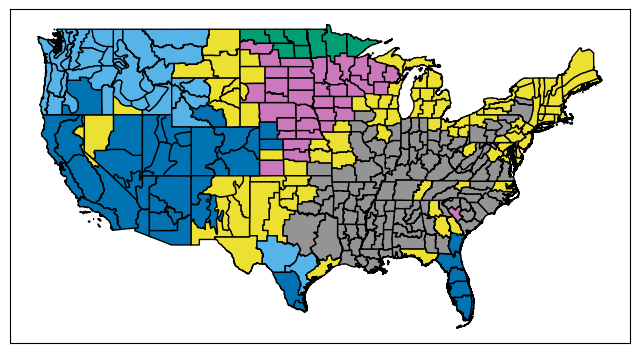

In [47]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = random_tree_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate6/randomized_imm.png', bbox_inches = 'tight', dpi = 300)

### Grid

In [74]:
climate_change.columns.get_loc('temp_july')

18

In [75]:
climate_change.columns.get_loc('pcpn_july')

6

In [106]:
cells = 3
features = [18,6]
grid = Grid(cells, features)
grid.fit(data)
grid_labels = grid.predict(data)

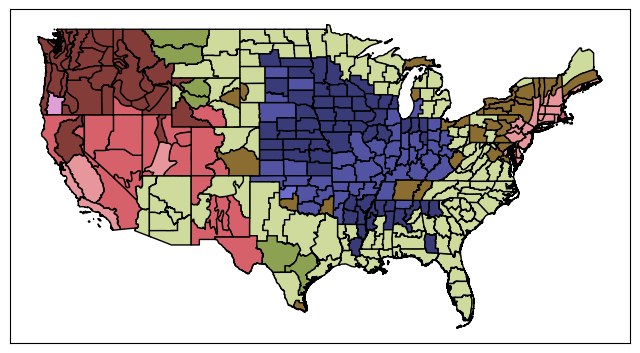

In [111]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = grid_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap='tab20b', ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)

plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate_grid/grid.png', bbox_inches = 'tight', dpi = 300)

## Rule Clustering

In [68]:
#max_leaves = 12
#rules = UnsupervisedTree(splits = 'axis', max_leaf_nodes = max_leaves, norm = 2)
max_leaves = 6
rules = CentroidTree(splits = 'oblique', max_leaf_nodes = max_leaves, norm = 2, center_init = 'manual', centers = kmeans.cluster_centers_)
rules.fit(data)

rule_kmeans = KMeansRuleClustering(rules, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
data_clustering, data_labels = rule_kmeans.predict(data, return_clustering = True)

In [112]:
k = 3
rules = grid

rule_kmeans = KMeansRuleClustering(rules, k_clusters = k, init = 'k-means', random_seed = seed)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
data_clustering, data_labels = rule_kmeans.predict(data, return_clustering = True)

In [85]:
rules.depth

AttributeError: 'Grid' object has no attribute 'depth'

In [102]:
rule_kmeans.cost

163.8951730050989

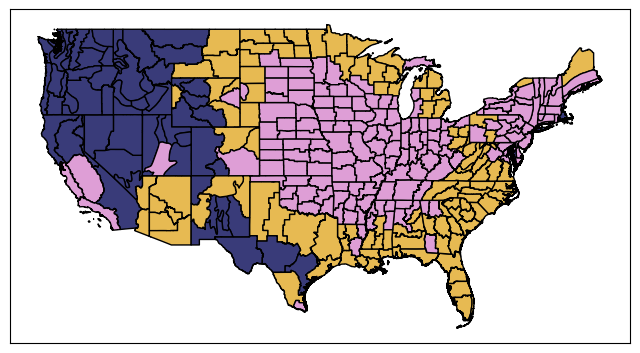

In [113]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
#gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
gdf.plot(column='cluster', cmap='tab20b', ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate6/centroid_oblique.png', bbox_inches = 'tight', dpi = 300)
#plt.savefig('figures/climate_grid/grid_cluster.png', bbox_inches = 'tight', dpi = 300)

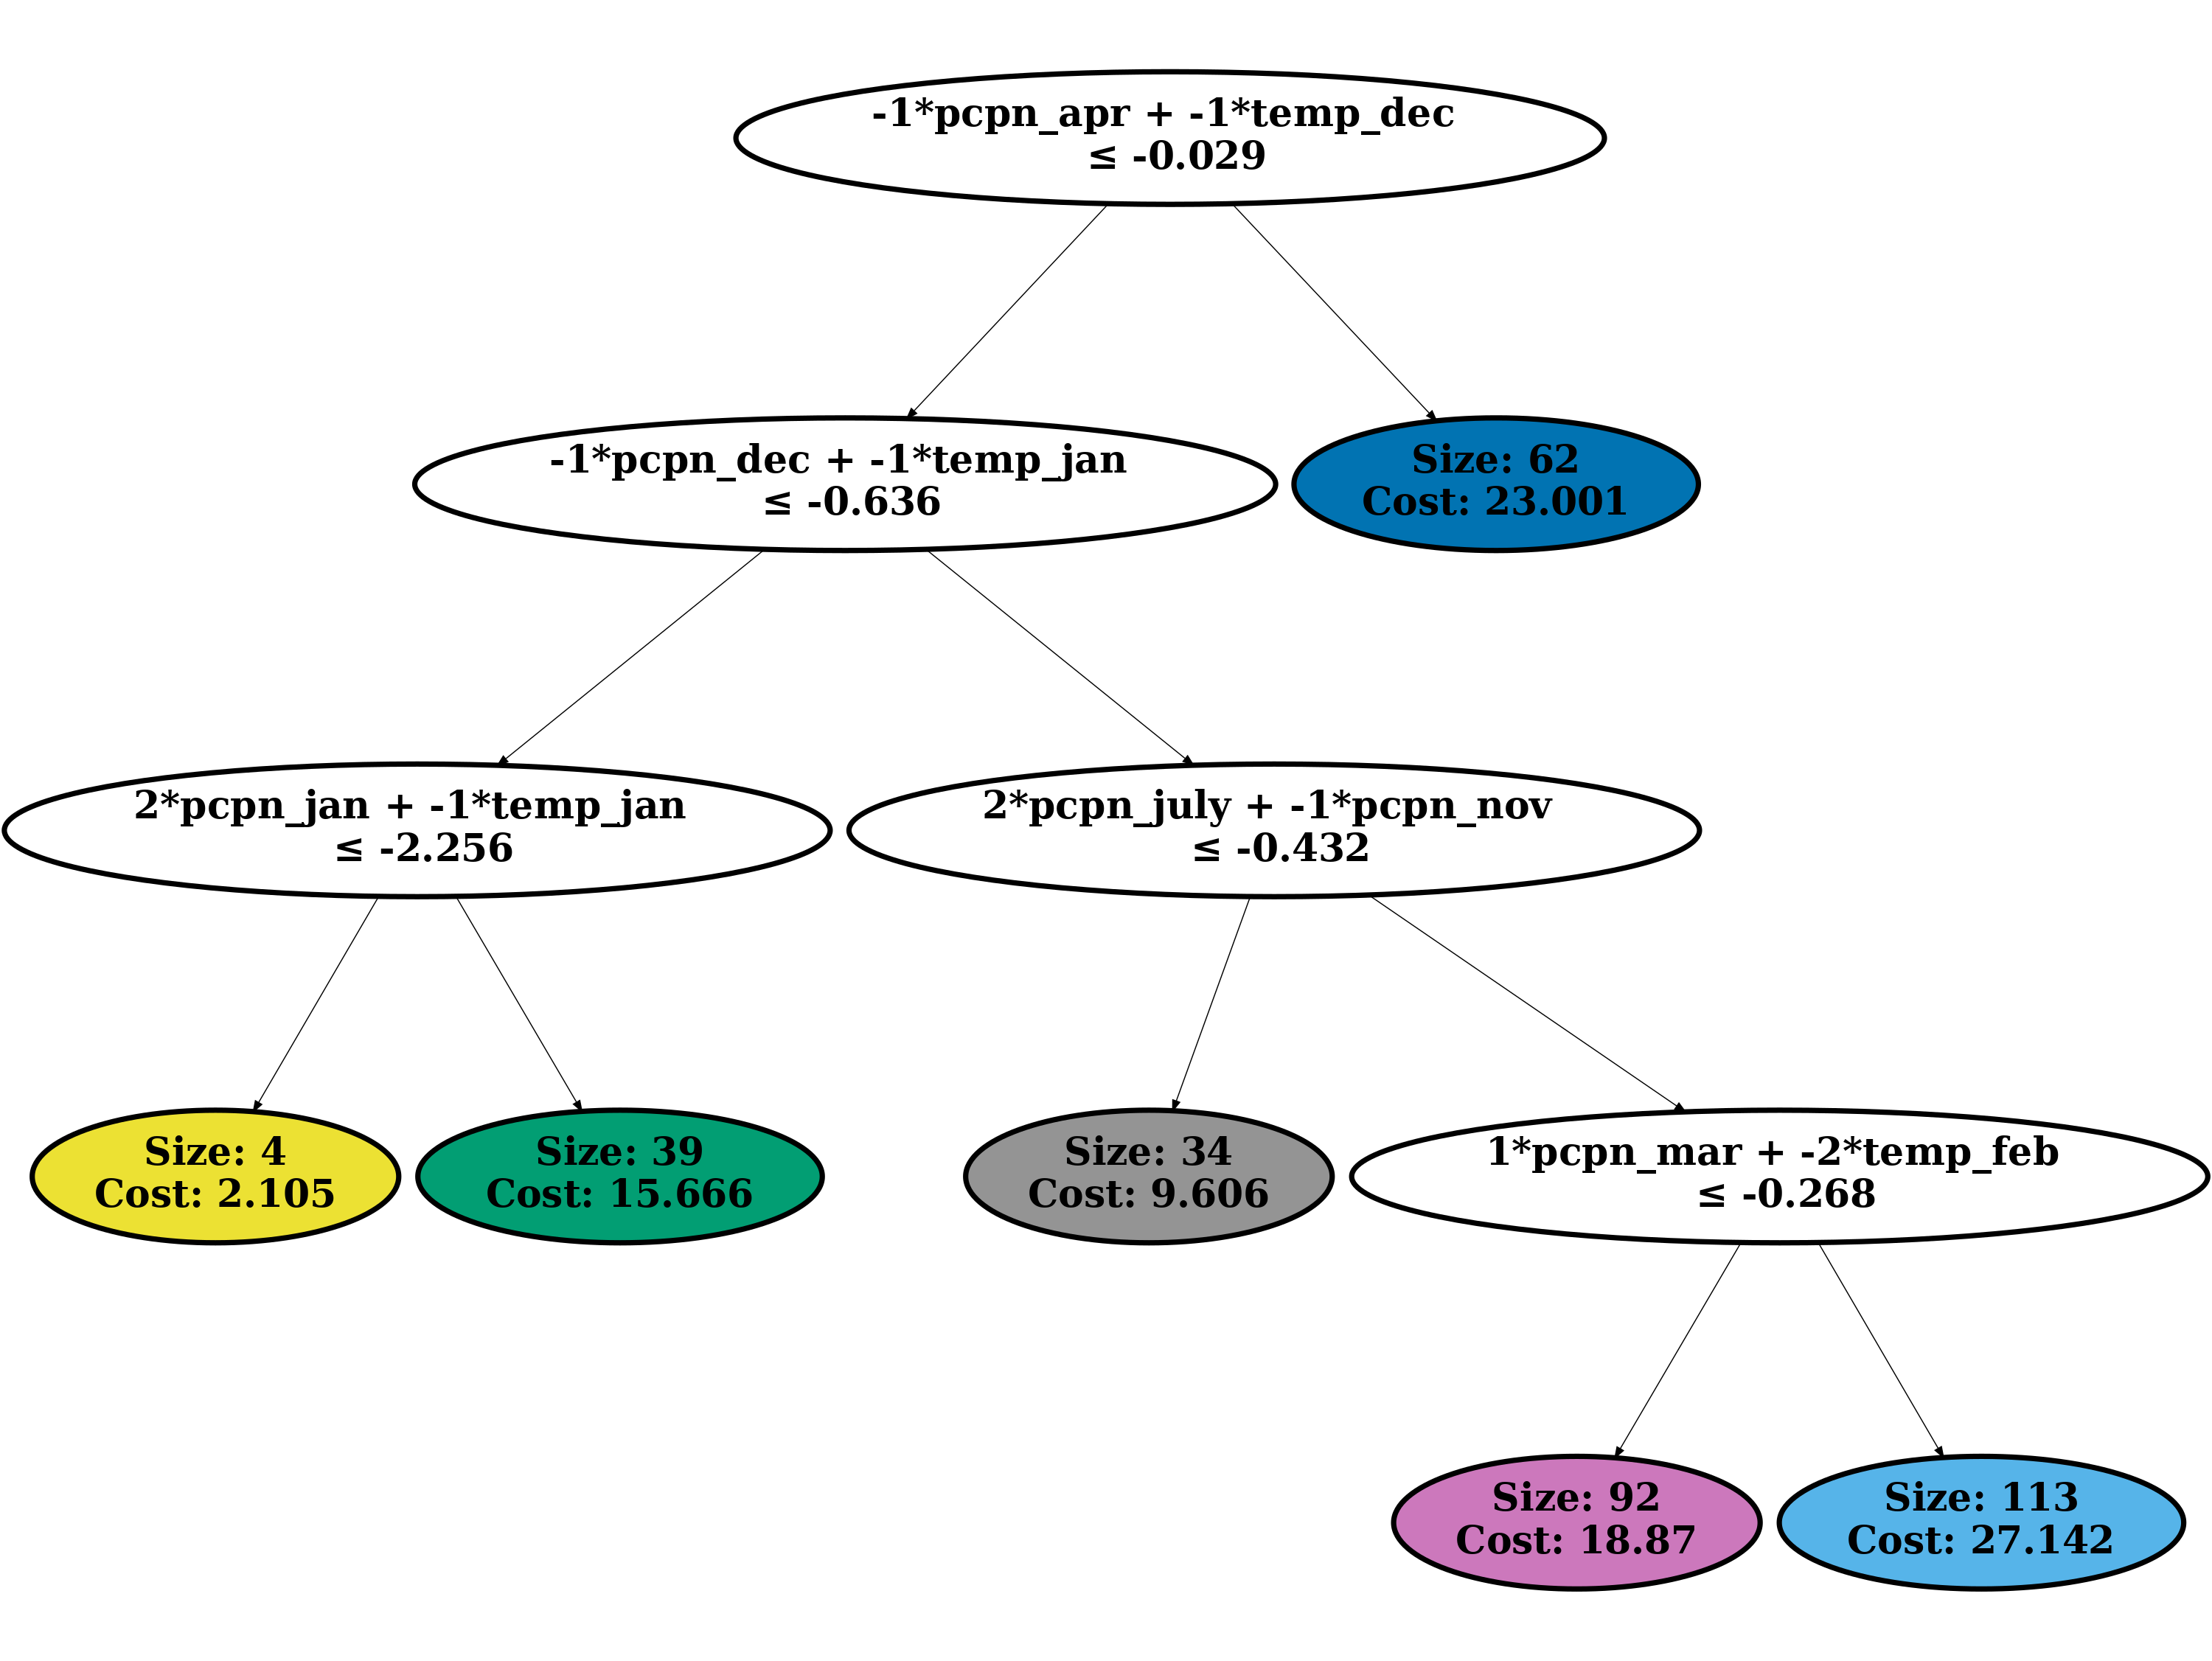

In [73]:
leaf_colors = {i:mcolors.rgb2hex(cmap_subset2(int(rule_labels[i]))) for i in range(max_leaves)}
visualize_tree(rules.root, output_file = 'figures/climate6/centroid_oblique_tree', feature_labels = feature_labels, leaf_colors = leaf_colors)

In [87]:
k

3

### Cost-Interpretability Tradeoff

In [113]:
exp = Experiment(data = data, n_clusters = 10, random_seed = seed, verbose = True)
exp.initialize()

Initializing k-means
Initializing IMM
Initializing Randomized IMM


In [114]:
exp.run_leaves_cost(min_leaves = 10, max_leaves = 32, clusterer = KMeansRuleClustering)

Initializing trees...
Number of leaves: 10
Number of leaves: 11
Number of leaves: 12
Number of leaves: 13
Number of leaves: 14
Number of leaves: 15
Number of leaves: 16
Number of leaves: 17
Number of leaves: 18
Number of leaves: 19
Number of leaves: 20
Number of leaves: 21
Number of leaves: 22
Number of leaves: 23
Number of leaves: 24
Number of leaves: 25
Number of leaves: 26
Number of leaves: 27
Number of leaves: 28
Number of leaves: 29
Number of leaves: 30
Number of leaves: 31
Number of leaves: 32


In [115]:
exp.run_depths_cost(min_depth = 4, max_depth = 10, max_leaves = 32, clusterer = KMeansRuleClustering)

Depth: 4
Depth: 5
Depth: 6
Depth: 7
Depth: 8
Depth: 9
Depth: 10


In [106]:
directory = '../data/experiments/climate/'
identifier = '_10_cluster'
exp.save_results(directory,identifier)

In [64]:
directory = '../data/experiments/climate/'
identifier = '_6_cluster'
leaves_cost_filename = os.path.join(directory, 'leaves_cost' + str(identifier) + '.csv')
leaves_depth_filename = os.path.join(directory, 'leaves_depth' + str(identifier) + '.csv')
leaves_iteration_filename = os.path.join(directory, 'leaves_iteration' + str(identifier) + '.csv')
depth_cost_filename = os.path.join(directory, 'depths_cost' + str(identifier) +  '.csv')

Text(0, 0.5, 'Cost')

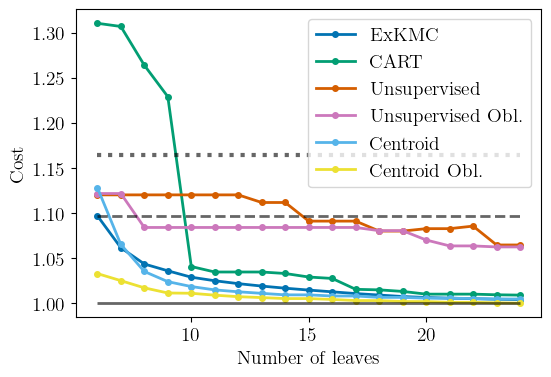

In [65]:
fig,ax = plt.subplots(figsize = (6,4))

leaves_cost_df = pd.read_csv(leaves_cost_filename, index_col = 0)
cost = leaves_cost_df['k-means'].iloc[0]
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
leaves = leaves_cost_df.index

ax.plot(leaves, np.array(leaves_cost_df['ExKMC'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(leaves_cost_df['CART'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(leaves_cost_df['Unsupervised Obl.'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(leaves_cost_df['Centroid'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(leaves_cost_df['Centroid Obl.'])/cost, linewidth = 2, marker='o', markersize = 4, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves[:end], np.array(leaves_cost_df['Hybrid'])[:end]/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves[:end], np.array(leaves_cost_df['Hybrid Obl.'])[:end]/cost, linewidth = 2, marker='o', markersize = 4, label = 'Hybrid Obl.', c = cmap(6))

ax.hlines(random_imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', linewidth = 3, alpha = 0.6)
ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', linewidth = 2, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', linewidth = 2, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')
#plt.savefig('figures/climate5/leaves_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

Text(0, 0.5, 'Depth')

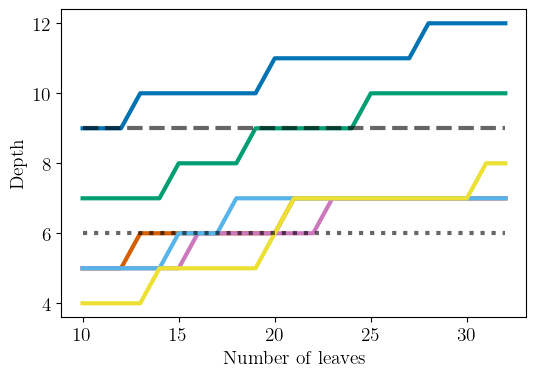

In [109]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = pd.read_csv(leaves_depth_filename, index_col = 0)
imm_depth = data_df['IMM'].iloc[0]
random_imm_depth = data_df['RandomIMM'].iloc[0]
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['ExKMC']), linewidth = 3, label = 'ExKMC', c = cmap(0))
ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(6))

ax.hlines(random_imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'RandomIMM', linewidth = 3, alpha = 0.6)
ax.hlines(imm_depth, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 3, alpha = 0.6)

#plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Depth')

Text(0, 0.5, 'Clustering Iterations')

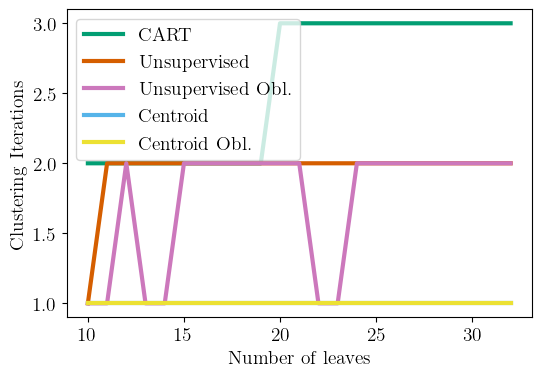

In [110]:
fig,ax = plt.subplots(figsize = (6,4))

data_df = pd.read_csv(leaves_iteration_filename, index_col = 0)
leaves = data_df.index 

ax.plot(leaves, np.array(data_df['CART']), linewidth = 3, label = 'CART', c = cmap(2))
ax.plot(leaves, np.array(data_df['Unsupervised']), linewidth = 3, label = 'Unsupervised', c = cmap(3))
ax.plot(leaves, np.array(data_df['Unsupervised Obl.']), linewidth = 3, label = 'Unsupervised Obl.', c = cmap(4))
ax.plot(leaves, np.array(data_df['Centroid']), linewidth = 3, label = 'Centroid', c = cmap(9))
ax.plot(leaves, np.array(data_df['Centroid Obl.']), linewidth = 3, label = 'Centroid Obl.', c = cmap(8))
#ax.plot(leaves, np.array(data_df['Hybrid']), linewidth = 3, label = 'Hybrid', c = cmap(1))
#ax.plot(leaves, np.array(data_df['Hybrid Obl.']), linewidth = 3, label = 'Hybrid Obl.', c = cmap(6))

plt.legend(loc = 'upper left')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Clustering Iterations')

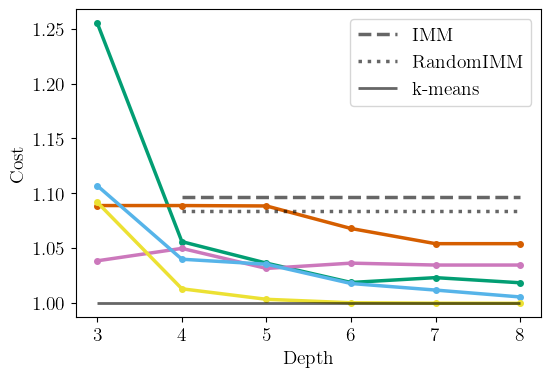

In [34]:
fig,ax = plt.subplots(figsize = (6,4))

depths_cost_df = pd.read_csv(depth_cost_filename, index_col = 0)
imm_cost = leaves_cost_df['IMM'].iloc[0]
random_imm_cost = leaves_cost_df['RandomIMM'].iloc[0]
depths = depths_cost_df.index 

ax.plot(depths, np.array(depths_cost_df['CART'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(2))
ax.plot(depths, np.array(depths_cost_df['Unsupervised'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(3))
ax.plot(depths, np.array(depths_cost_df['Unsupervised Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(4))
ax.plot(depths, np.array(depths_cost_df['Centroid'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(9))
ax.plot(depths, np.array(depths_cost_df['Centroid Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(8))
#ax.plot(depths, np.array(depths_cost_df['Hybrid'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(1))
#ax.plot(depths, np.array(depths_cost_df['Hybrid Obl.'])/cost, linewidth = 2.5, marker='o', markersize = 4, c = cmap(6))

ax.plot(depths, np.array(depths_cost_df['IMM'])/cost, linewidth = 2.5, label = 'IMM', c = 'k', linestyle = '--', alpha = 0.6)
ax.plot(depths, np.array(depths_cost_df['RandomIMM'])/cost, linewidth = 2.5, label = 'RandomIMM', c = 'k', linestyle = 'dotted', alpha = 0.6)
#ax.hlines(exp.imm_cost/cost, xmin = exp.imm_depth, xmax = depths[-1], color = 'k', linestyle = '--', label = 'IMM', linewidth = 2, alpha = 0.6)
ax.hlines(cost/cost, xmin = depths[0], xmax = depths[-1], color = 'k', linestyle = '-', label = 'k-means', linewidth = 2, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Depth')
ax.set_ylabel('Cost')
#plt.savefig('figures/climate5/depth_cost_compare.jpg', bbox_inches = 'tight', dpi = 300)

In [112]:
exp.imm_depth

9